In [197]:
# IMPORT LIBRARIES
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from AI.algorithms_from_scratch.my_base_models import MySupportVectorRegressionBase


In [198]:
# GENERATE DATA
np.random.seed(42)
X, y = make_regression(n_samples=1_000, n_features=1, noise=12)


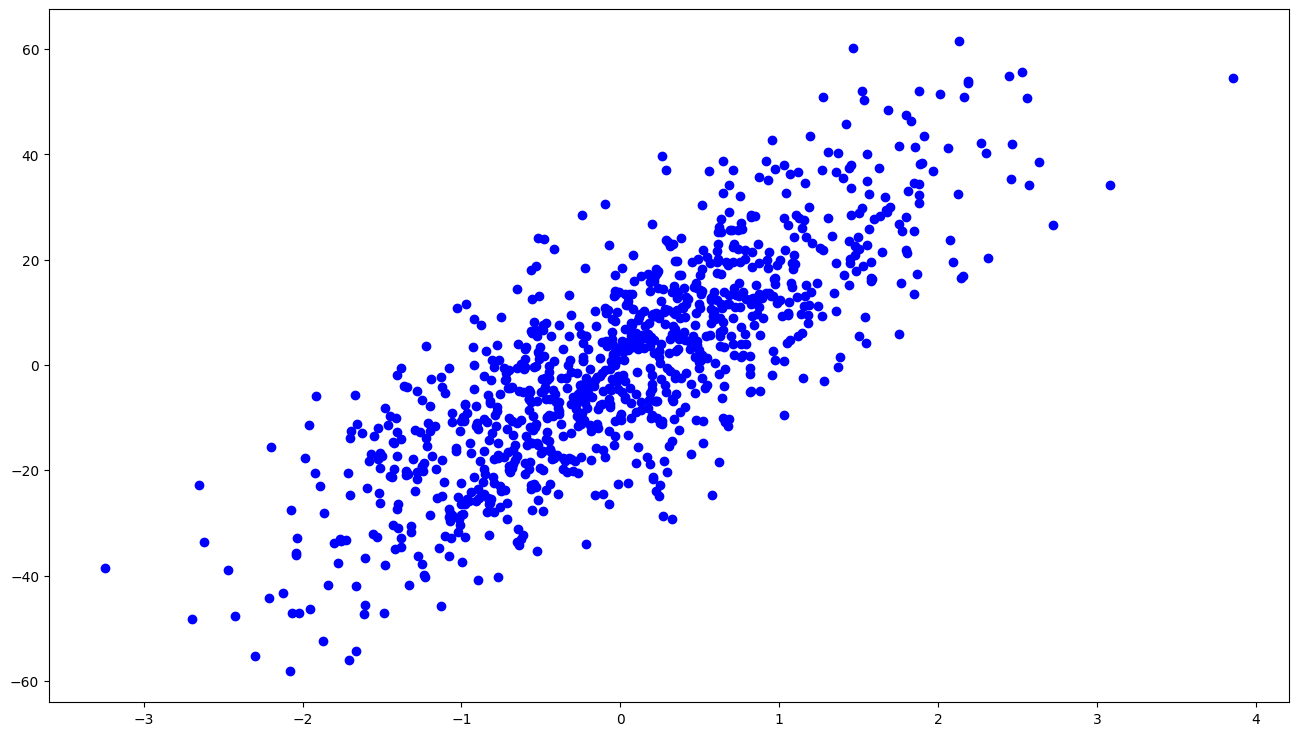

In [199]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.scatter(X, y, c='blue')
plt.show()


In [200]:
X

array([[-1.75873949e+00],
       [ 1.03184454e+00],
       [-4.87606224e-01],
       [ 1.86454315e-01],
       [ 7.25766624e-01],
       [ 9.72554450e-01],
       [ 6.45375950e-01],
       [ 6.81891490e-01],
       [-1.43014138e+00],
       [ 1.06667469e+00],
       [ 1.55050049e+00],
       [-1.55677235e-01],
       [-2.69874935e-01],
       [-2.30192116e+00],
       [-1.86726519e+00],
       [-7.44334291e-02],
       [ 5.88317206e-01],
       [ 1.20650897e+00],
       [-1.92360965e-01],
       [ 1.11957491e+00],
       [-3.09546439e-01],
       [-1.28030440e+00],
       [ 1.30714275e+00],
       [ 1.17944012e+00],
       [ 8.65897875e-02],
       [ 4.73832921e-01],
       [ 4.29618219e-01],
       [ 4.89374561e-01],
       [-1.40746377e+00],
       [-5.03475654e-01],
       [-5.52223044e-01],
       [-8.22220396e-01],
       [ 1.54993441e+00],
       [ 5.76556963e-01],
       [ 2.32049937e-01],
       [ 3.38496407e-01],
       [-3.76347024e-02],
       [-8.15810285e-01],
       [-1.4

In [201]:
# SCALE DATA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [202]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [203]:
# CREATE MODEL
# CREATE LINEAR SUPPORT VECTOR REGRESSOR
from sklearn.base import BaseEstimator

class MyLinearSVR(BaseEstimator, MySupportVectorRegressionBase):
    def __init__(self, eta0=1, eta_d=1000, n_epochs=1000, epsilon=0.1):
        """
        This class implements a linear Support Vector Regressor. It aims to find a 
        hyperplane that best fits the data within a margin of tolerance, epsilon.
        
        :param eta0: Initial learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param epsilon: Epsilon parameter - control how wide the margin is
        """
        super().__init__()
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.epsilon = epsilon
        self.Js = []  # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None

    def fit(self, X, y):
        """
        Fits the linear SVR model to the training data.
        
        :param X: Feature dataset
        :param y: Target values
        :returns: self
        """
        # Random initialization of weights and bias
        coef_ = np.random.randn(X.shape[1], 1)  # number of feature weights
        intercept_ = 0

        # Training
        for epoch in range(self.n_epochs):
            errors = y - (X.dot(coef_) + intercept_).ravel()

            # Support vectors are those outside the epsilon margin
            mask = np.abs(errors) > self.epsilon
            X_sv = X[mask]
            y_sv = y[mask]
            errors_sv = errors[mask].reshape(-1, 1)

            # Epsilon-insensitive loss (for visualization purposes)
            J = 1 / 2 * (coef_ * coef_).sum() + np.sum(np.maximum(0, np.abs(errors_sv) - self.epsilon))
            self.Js.append(J)

            # Compute gradients
            w_gradient_vector = coef_ - (X_sv * np.sign(errors_sv)).sum(axis=0).reshape(-1, 1)
            b_derivative = -np.sign(errors_sv).sum()

            # Update weights and bias
            eta = self.eta(epoch)
            coef_ = coef_ - eta * w_gradient_vector
            intercept_ = intercept_ - eta * b_derivative
        self.mask = mask
        self.intercept_ = np.array([intercept_])
        self.coef_ = coef_.reshape(1, -1)
        self.support_vectors_ = X[mask]
        return self

    def predict(self, X):
        """
        Predict the target values using the trained linear SVR model.
        
        :param X: Feature dataset
        :returns: Predicted target values
        """
        return X.dot(self.coef_.T).ravel() + self.intercept_



# Example usage:
# model = MyLinearSVR(eta0=0.01, eta_d=1000, n_epochs=500, epsilon=0.1)
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)


In [204]:
# FIT MODEL
svr = MyLinearSVR(eta0=1, eta_d=1000, n_epochs=1_000, epsilon=20)
svr.fit(X_train, y_train)

MyLinearSVR(epsilon=20)

In [205]:
# PREDICT
y_pred = svr.predict(X_test)


In [206]:
# CROSS VALIDATION
scores = cross_val_score(svr, X_test, y_test, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print(f'Mean: {rmse_scores.mean()}')
rmse_scores

Mean: 11.945452551708819


array([11.40828422, 12.13378217, 11.06911805, 12.01471783, 12.35476513,
       12.17831246, 14.80592354,  9.06322094, 11.82168668, 12.60471449])

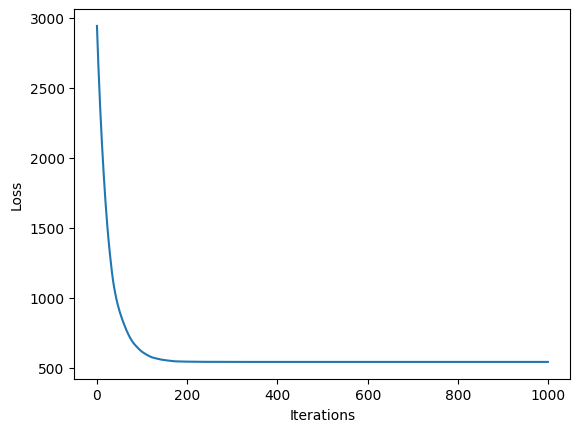

In [207]:
# PLOT TRAINING LOSS
svr.show_loss_curve()

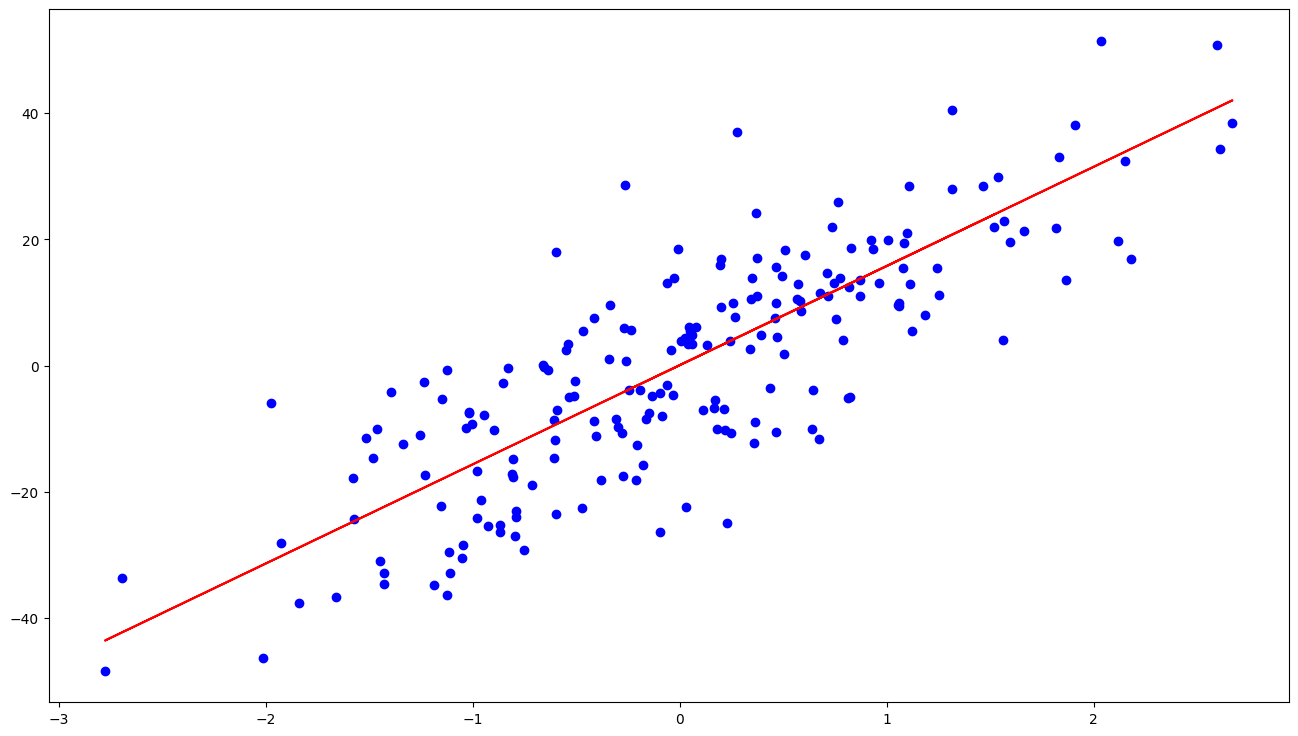

In [208]:
# PLOT PREDICTIONS
plt.figure(figsize=(16, 9))
plt.scatter(X_test, y_test, c='blue')
plt.plot(X_test, y_pred, c='red')
plt.show()


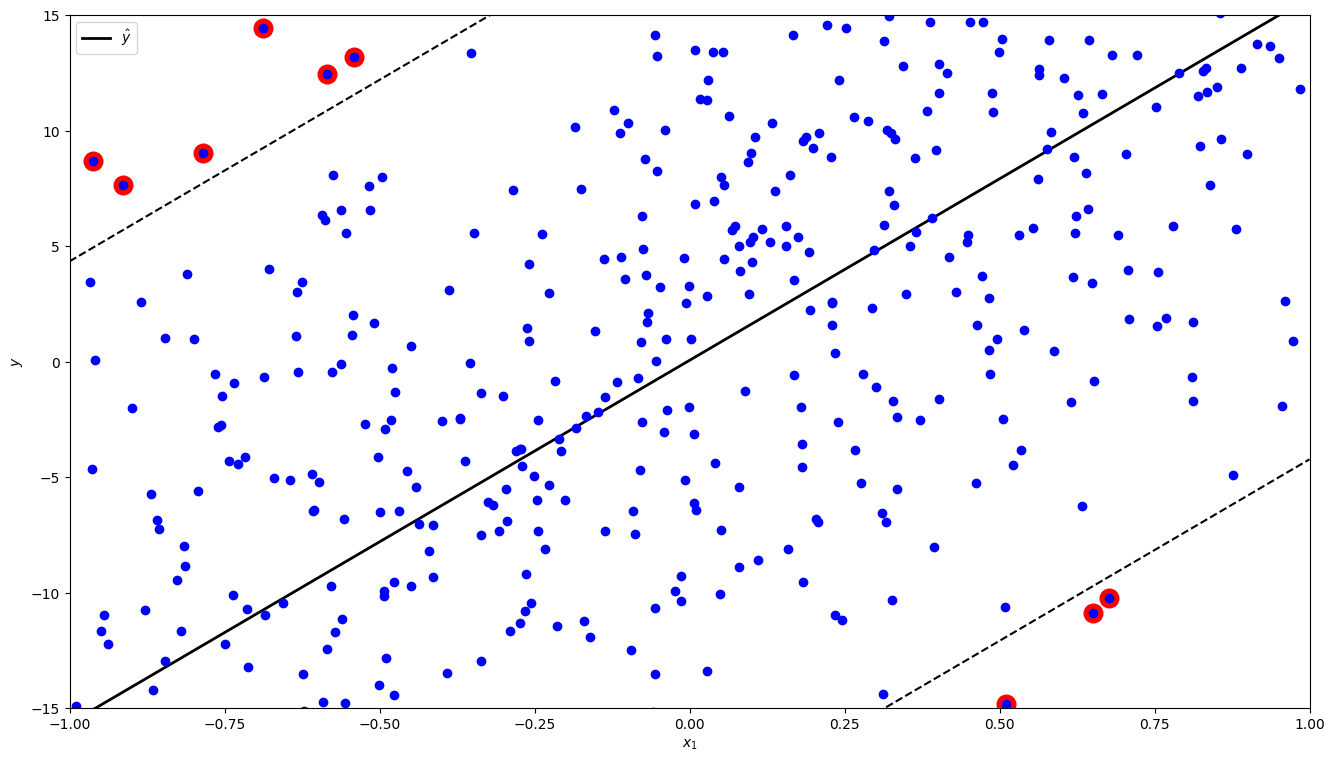

In [209]:
# PLOT PREDICTIONS
# EPS = 12
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    # epsilon = EPS
    epsilon = svm_reg.epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    plt.figure(figsize=(16, 9))
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    # epsilon = EPS
    epsilon = svm_reg.epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg.mask], y[svm_reg.mask], s=180,
                facecolors='#FF0000', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svr.support_vectors_ = find_support_vectors(svr, X_train, y_train)

plot_svm_regression(svr, X_train, y_train, [-1, 1, -15, 15])

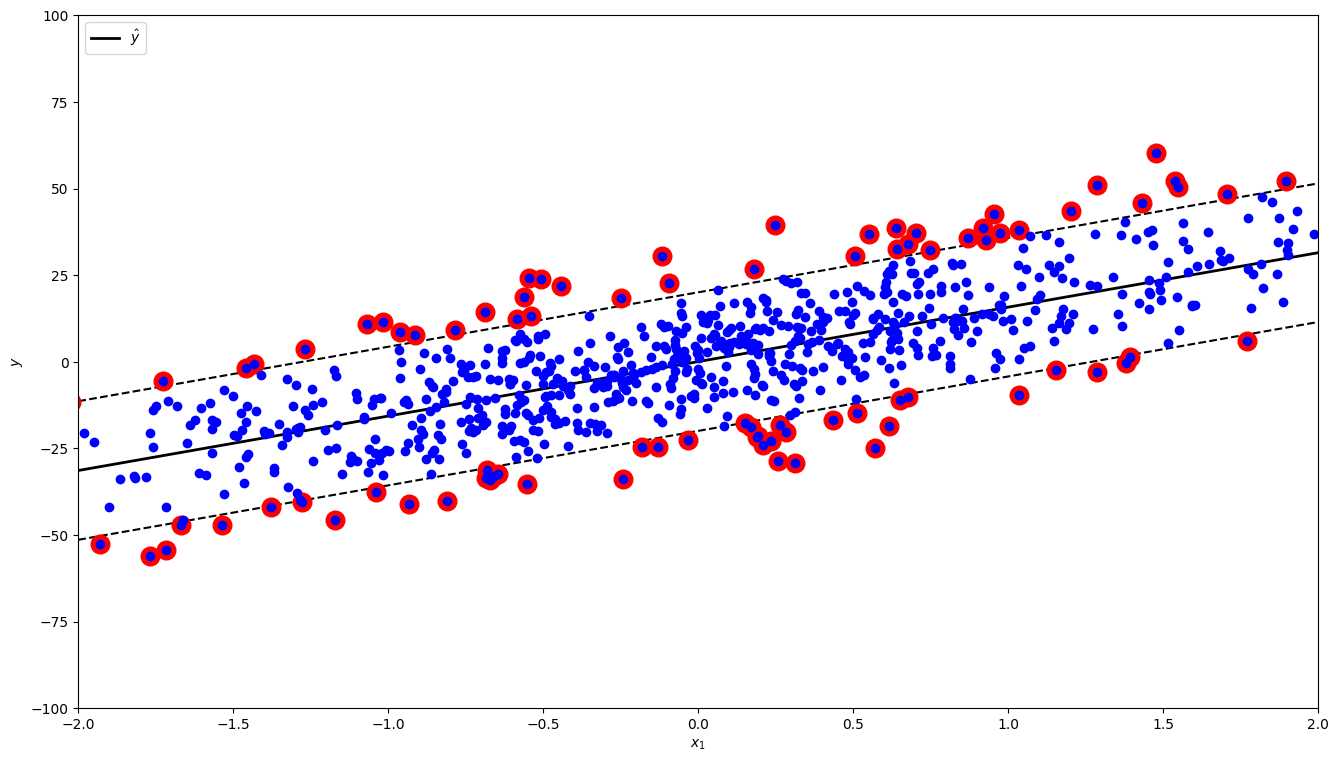

In [210]:
plot_svm_regression(svr, X_train, y_train, [-2, 2, -100, 100])